# Variable-Input, Variable-Output (VIVO) Human-in-the-Loop Hybrid Test and Evaluation Framework for AI Systems

Author: Rich Bauder

Version: 0.1

This notebook defines a generalized, hybrid test and evaluation (T&E) framework for comparing AI models that operate on different input sources and produce heterogeneous or cross-format outputs. The workflow integrates human expert assessment with LLM-assisted meta-evaluation to ensure comprehensive, consistent, and interpretable performance analysis where automated metrics alone are inadequate.

**Process Overview**

The AI T&E framework proceeds in five stages:

1. Data Sampling and Alignment
  Input datasets are sampled and aligned through fuzzy or semantic similarity matching to generate comparable evaluation instances across models.

2. Model Output Generation and Preparation
  Each AI model produces outputs from the aligned test instances. These outputs may vary in structure, format, or expressiveness, reflecting the models’ differing architectures or modalities.

3. Expert Evaluation Assignment
  Model outputs are distributed to Subject Matter Experts (SMEs) for structured scoring (quantitative) and commentary (qualitative). This step emphasizes interpretability and contextual judgment over automated scoring metrics.

4. LLM-Assisted Qualitative Meta-Analysis and Evaluation of SME Feedback
  A Large Language Model (LLM) is used to perform a meta-analysis of SME evaluations. This stage provides a secondary, qualitative validation layer that complements statistical testing, helping identify subtle or narrative patterns in SME feedback that numeric measures may miss.

5. Score Aggregation and Statistical Analysis
  SME and LLM-derived evaluations are synthesized and analyzed through descriptive and inferential statistics, including mean, variance, Mann–Whitney U, Kolmogorov–Smirnov, and Intraclass Correlation Coefficient (ICC) tests. The results quantify model performance differences, inter-rater reliability, and the significance of observed trends.

## Import packages

Print python and package versions.

In [3]:
import pandas as pd
import numpy as np
import random
import sys
import os
import random
from textwrap import dedent
from collections import defaultdict
from datetime import datetime, timedelta
import pingouin as pg
from skimpy import skim
from scipy.stats import (mannwhitneyu, ks_2samp)
from sklearn.model_selection import StratifiedShuffleSplit
from rapidfuzz import fuzz
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(1984)
random.seed(1984)

In [2]:
print("Python version:", sys.version)

Python version: 3.12.9 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 12:55:12) [Clang 14.0.6 ]


## Data Preprocessing

### 1) Ingest and join A and B datasets

This will likely be csv reads or database pulls (e.g. Spark Tables in Databricks or S3 files). Note, in Step 2, we will need to define the shared (overlapping) features used between both datasets. This could be done in parallel, so we can subset the data on read rather than reading in all the data then subsetting.

In [25]:
file_path_A = '.'
file_path_B = '.'

In [32]:
def get_data(directory, filter_string, ext='csv'):
    csv_files = [
        f.path for f in os.scandir(directory)
        if f.is_file()
        and f.name.lower().endswith(f'.{ext.lower()}')
        and f.name.startswith(filter_string)
    ]

    df_list = []
    for file_path in csv_files:
        try:
            df = pd.read_csv(file_path)
            df['source_file'] = os.path.basename(file_path)
            df_list.append(df)
        except Exception as e:
            print(f"Error reading {file_path}: {e}")

    return df_list

In [33]:
dfs_A = get_data(file_path_A, filter_string='random_input_100_A')
dfs_B = get_data(file_path_B, filter_string='random_input_100_B')

In [35]:
print(len(dfs_A))
print(dfs_A[0].columns)

1
Index(['id', 'education_level', 'education_major_at_highest_level',
       'current_job_title', 'sex', 'zip_code', 'certifications', 'birth_date',
       'current_job_start_date', 'years_experience', 'source_file'],
      dtype='object')


In [36]:
print(len(dfs_B))
print(dfs_B[0].columns)

1
Index(['id', 'education_level', 'education_major_at_highest_level',
       'current_job_title', 'sex', 'zip_code', 'certifications', 'birth_date',
       'current_job_start_date', 'years_experience', 'source_file'],
      dtype='object')


Drop same columns with different values (i.e. the values don't match within same column names--data not consistent).

In [37]:
def check_cols(dfs, id_col="id"):
  diff_cols = set()
  
  for i in range(len(dfs)):
    for j in range(i + 1, len(dfs)):
      common_cols = list(set(dfs[i].columns) & set(dfs[j].columns))
      common_cols.remove(id_col)
      for col in common_cols:
        if not dfs[i][col].equals(dfs[j][col]):
          diff_cols.add(col)

  return diff_cols

In [38]:
print(check_cols(dfs_A)) # should be an empty set
print(check_cols(dfs_B))

set()
set()


Function to merge dataframes and do any string padding.

In [39]:
def join_df(dfs, join_on='id', join_how='inner', 
            pad_len=0, pad_fill='', pad_cols=['current_job_title']):
  diff_cols = check_cols(dfs, join_on)
  dfs1 = [df.drop(columns=diff_cols.intersection(df.columns)) for df in dfs]
  
  merged_df = dfs1[0]
  for df in dfs1[1:]:
    merged_df = pd.merge(merged_df, df, on=join_on, how=join_how)

  for col in pad_cols:
    if col in merged_df.columns:
      merged_df[col] = merged_df[col].astype(str).str.pad(4, side='left', fillchar='0')

  return merged_df

In [40]:
merged_df_A = join_df(dfs_A)
print(merged_df_A.shape)

# merged_df_A = merged_df_A.rename(columns={
#     'x': 'y',
# })

(100, 11)


In [41]:
merged_df_B = join_df(dfs_B)
print(merged_df_B.shape)

(100, 11)


In [0]:
# Another check for column duplicates.
# cnames = [col.rsplit('_df', 1)[0] for col in merged_df_B.columns]
# seen_it = set()
# dups = set()
#
# for name in cnames:
#   if name in seen_it:
#     dups.add(name)
#   else:
#     seen_it.add(name)
#
# print(dups)

### 2) EXTERNAL ACTION REQUIRED: Define overlapping features

**Responsible Parties: Test Organizer and selected SMEs**

Need to determine which shared features between A and B should be used to assess similarity between these two datasets. In other words, what features (or fields) should be used to fairly assess similarity between data.

### 3) Prepare data from similarity step

In [42]:
overlapping_cols = ['id', 'education_level', 'current_job_title', 'current_job_start_date', 'education_major_at_highest_level',
                    'sex', 'birth_date', 'zip_code',]

merged_df_A_sub = merged_df_A[overlapping_cols]
merged_df_B_sub = merged_df_B[overlapping_cols]

In [44]:
print(merged_df_B_sub.isna().sum())
print(merged_df_A_sub.isna().sum())

id                                  0
education_level                     0
current_job_title                   0
current_job_start_date              0
education_major_at_highest_level    0
sex                                 0
birth_date                          0
zip_code                            0
dtype: int64
id                                  0
education_level                     0
current_job_title                   0
current_job_start_date              0
education_major_at_highest_level    0
sex                                 0
birth_date                          0
zip_code                            0
dtype: int64


In [45]:
print(merged_df_B_sub.shape)
merged_df_B_sub = merged_df_B_sub.dropna(how='any')
print(merged_df_A_sub.shape)
merged_df_A_sub = merged_df_A_sub.dropna(how='any')

(100, 8)
(100, 8)


Extract month and year from datetime variables.

In [46]:
merged_df_A_sub['birth_date'] = pd.to_datetime(merged_df_A_sub['birth_date'], errors='coerce')
merged_df_A_sub['current_job_start_date'] = pd.to_datetime(merged_df_A_sub['current_job_start_date'], errors='coerce')
merged_df_A_sub.loc[:, 'birth_date_month'] = merged_df_A_sub['birth_date'].dt.strftime('%B')
merged_df_A_sub.loc[:, 'birth_date_year'] = merged_df_A_sub['birth_date'].dt.year.astype('Int64').astype(str)
merged_df_A_sub.loc[:, 'current_job_start_date_month'] = merged_df_A_sub['current_job_start_date'].dt.strftime('%B')
merged_df_A_sub.loc[:, 'current_job_start_date_year'] = merged_df_A_sub['current_job_start_date'].dt.year.astype('Int64').astype(str)

merged_df_B_sub['birth_date'] = pd.to_datetime(merged_df_B_sub['birth_date'], errors='coerce')
merged_df_B_sub['current_job_start_date'] = pd.to_datetime(merged_df_B_sub['current_job_start_date'], errors='coerce')
merged_df_B_sub.loc[:, 'birth_date_month'] = merged_df_B_sub['birth_date'].dt.strftime('%B')
merged_df_B_sub.loc[:, 'birth_date_year'] = merged_df_B_sub['birth_date'].dt.year.astype('Int64').astype(str)
merged_df_B_sub.loc[:, 'current_job_start_date_month'] = merged_df_B_sub['current_job_start_date'].dt.strftime('%B')
merged_df_B_sub.loc[:, 'current_job_start_date_year'] = merged_df_B_sub['current_job_start_date'].dt.year.astype('Int64').astype(str)

In [47]:
merged_df_B_sub = merged_df_B_sub.drop(['birth_date', 'current_job_start_date',], axis=1)
merged_df_A_sub = merged_df_A_sub.drop(['birth_date', 'current_job_start_date',], axis=1)

In [48]:
merged_df_B_sub = merged_df_B_sub.sample(n=50, random_state=1984).reset_index(drop=True)
merged_df_A_sub = merged_df_A_sub.sample(n=50, random_state=1984).reset_index(drop=True)

In [49]:
# redefined overlapping columns based on datetime transformations
overlapping_cols = ['id', 'education_level', 'current_job_title', 'education_major_at_highest_level', 'sex', 'zip_code',
                    'birth_date_month', 'birth_date_year', 'current_job_start_date_month',
                    'current_job_start_date_year']

Optional filtering.

In [0]:
# values = []
# merged_df_A_sub = merged_df_A_sub.query("VAR not in @values")
# merged_df_B_sub_sample = merged_df_B_sub_sample.query("VAR not in @values")

In [50]:
dfA = merged_df_A_sub.copy()
dfA.head()

,id,education_level,current_job_title,education_major_at_highest_level,sex,zip_code,birth_date_month,birth_date_year,current_job_start_date_month,current_job_start_date_year
0,156,Masters,Systems Analyst,Mathematics,F,30309,August,1990,October,2015
1,129,Masters,Marketing Specialist,Psychology,F,98101,November,1995,January,2020
2,162,Bachelors,Software Engineer,Mathematics,F,80202,March,1976,January,2021
3,191,Masters,Data Analyst,Business Administration,M,33101,January,1975,April,2013
4,154,Masters,QA Tester,Data Science,F,30309,May,1999,March,2024


In [51]:
dfB = merged_df_B_sub.copy()
dfB.head()

,id,education_level,current_job_title,education_major_at_highest_level,sex,zip_code,birth_date_month,birth_date_year,current_job_start_date_month,current_job_start_date_year
0,156,Masters,Systems Analyst,Mathematics,F,30309,August,1990,October,2015
1,129,Masters,Marketing Specialist,Psychology,F,98101,November,1995,January,2020
2,162,Bachelors,Software Engineer,Mathematics,F,80202,March,1976,January,2021
3,191,Masters,Data Analyst,Business Administration,M,33101,January,1975,April,2013
4,154,Masters,QA Tester,Data Science,F,30309,May,1999,March,2024


In [52]:
# quick check on column names
for col in overlapping_cols:
  if col not in dfA.columns or col not in dfB.columns:
    raise ValueError(f"Missing expected column: {col}")

dfA1 = dfA[overlapping_cols].copy()
dfB1 = dfB[overlapping_cols].copy()

In [53]:
dfA1.reset_index(drop=True, inplace=True)
dfB1.reset_index(drop=True, inplace=True)

In [54]:
print(dfA1.shape)
print(dfB1.shape)

(50, 10)
(50, 10)


## Similarity matching

Fuzzy matching, based on a set threshold, across rows between A and B datasets to determine most similar test (input) datasets given agreed-upon overlapping features in both. Note this is similar in concept to Propensity Score Matching used in domains such as marketing [1]. Generates high-similarity (based on user-defined threshold) row pairs that can be used to create comparable test data with partially overlapping or some (hopefully) heterogeneous structures.

Process Summary:

- Iterates through each row in Dataset A and compares it to all rows in Dataset B.
- For every overlapping feature:
  - Calculates a fuzzy string similarity score using `fuzz.ratio()` (Levenshtein distance–based).
  - Computes the average similarity across all overlapping features for each row pair.
- Keeps only the highest-scoring match per A-row that meets the defined `similarity_threshold`.
- Prevents reusing the same B-row by tracking matched indices (`used_b_indices`).
- Returns up to `n_samples` top-ranked pairs, sorted by descending similarity score.

Note:

`fuzz.ratio()` is one of several fuzzy string similarity methods available. Alternatives such as partial_ratio or token_sort_ratio may be used depending on the data type and matching requirements.

In [0]:
# testing the fuzzy matching
#fuzz.ratio("the cat is fluffy!", "fluffy is a three-headed dog.")

In [55]:
def create_comparable_test_sets(dataset_a, dataset_b, overlapping_cols, similarity_threshold=0.8, n_samples=100):
    matched_pairs = []
    used_b_indices = set()
    
    for idx_a, row_a in dataset_a.iterrows():
        best_match = None
        best_score = 0
        
        for idx_b, row_b in dataset_b.iterrows():
            # skip if B index matched
            if idx_b in used_b_indices:
                continue
            
            similarities = []
            for feature in overlapping_cols:
                if pd.notna(row_a[feature]) and pd.notna(row_b[feature]):
                    sim_score = fuzz.ratio(str(row_a[feature]), str(row_b[feature])) / 100.0
                    similarities.append(sim_score)
            
            avg_similarity = np.mean(similarities) if similarities else 0
            
            if avg_similarity > best_score and avg_similarity >= similarity_threshold:
                best_score = avg_similarity
                best_match = (idx_a, idx_b, avg_similarity)
        
        if best_match:
            matched_pairs.append(best_match)
            used_b_indices.add(best_match[1])  # marked b matched
    
    matched_pairs.sort(key=lambda x: x[2], reverse=True)
    return matched_pairs[:n_samples]


In [56]:
%%time

cnames = [c for c in overlapping_cols if c != 'id']
matched_test_cases = create_comparable_test_sets(dfA1, dfB1, cnames, similarity_threshold=0.55, n_samples=50)

CPU times: user 68.3 ms, sys: 2.06 ms, total: 70.4 ms
Wall time: 70.1 ms


In [58]:
matched_test_cases[:10]

[(0, 0, np.float64(1.0)),
 (1, 1, np.float64(1.0)),
 (2, 2, np.float64(1.0)),
 (3, 3, np.float64(1.0)),
 (4, 4, np.float64(1.0)),
 (5, 5, np.float64(1.0)),
 (6, 6, np.float64(1.0)),
 (7, 7, np.float64(1.0)),
 (8, 8, np.float64(1.0)),
 (9, 9, np.float64(1.0))]

The following maps the matched index pairs and similarity scores back to their original datasets to create full test subsets. Creates similarity-annotated subsets from the matched pairs (above), for downstream comparisons, visualizations, and SME assessments.

Process Summary:

- Extracts the indices and similarity scores from the matched_pairs list.
- Retrieves the corresponding rows from Dataset A and Dataset B.
- Resets indices to align both DataFrames.
- Adds metadata columns:
  - `sim_score`: average similarity between matched rows
  - `orig_index`: original index in the source dataset
  - `src`: dataset label (A or B, in this case)
- Returns two aligned DataFrames (`mapped_df_a`, `mapped_df_b`).

In [59]:
def map_indices_to_dataframes(sim_pairs, dataset_a, dataset_b):
    indices_a = [pair[0] for pair in sim_pairs]
    indices_b = [pair[1] for pair in sim_pairs]
    sim_scores = [pair[2] for pair in sim_pairs]
    
    mapped_df_a = dataset_a.loc[indices_a].copy()
    mapped_df_b = dataset_b.loc[indices_b].copy()
    mapped_df_a = mapped_df_a.reset_index(drop=True)
    mapped_df_b = mapped_df_b.reset_index(drop=True)
    
    mapped_df_a['sim_score'] = sim_scores
    mapped_df_a['orig_index'] = indices_a
    mapped_df_a['src'] = 'A'
    mapped_df_b['sim_score'] = sim_scores  
    mapped_df_b['orig_index'] = indices_b
    mapped_df_b['src'] = 'B'
    
    return mapped_df_a, mapped_df_b

In [60]:
top_sim_A, top_sim_B = map_indices_to_dataframes(matched_test_cases, dfA1, dfB1)

In [61]:
print(top_sim_A.shape)
print(top_sim_B.shape)

min_rows = min(top_sim_A.shape[0], top_sim_B.shape[0])
print(min_rows)

(50, 13)
(50, 13)
50


### OPTION 1 (fuzzy failure)

#### Stratified Sampling Based on Overlapping Features 

(*fallback if similarity underperforms*)

Use this method only if fuzzy similarity or comparable instance-matching approaches fail, for example:

- Calculated similarity scores between datasets are consistently low, indicating that few records share overlapping or comparable feature values.
- The data used for matching is too sparse, inconsistent, or noisy, preventing stable pairwise alignment.
- The datasets represent different but related populations, where direct one-to-one row matching is not meaningful.

In these cases, stratified sampling provides an alternative approach to ensure each dataset contributes representative, comparable subsets for evaluation.

Basic outline:

- Identify key categorical or numeric features that best represent the structure of each dataset (e.g., topic category, domain label, region, or complexity level).
- Use these features to perform stratified random sampling, ensuring each subset has a similar distribution across those features.
- The resulting subsets are not matched on a row-by-row basis but are distributionally comparable, preserving balance across important variables.

Note:

May need to reduce the number of fields in the overlap to allow for more rows within each group (key). Too many fields make each key (concatenated strings) as unique thus one per group (and no real stratification done).

In [0]:
# def strat_sample(df, cols, n_rows, seed=1984, min_group_size=3):
#     key = df[cols].astype(str).agg('_'.join, axis=1)
#     valid_mask = key.map(key.value_counts()) >= min_group_size
#     df_valid = df[valid_mask].reset_index(drop=True)
#     key_valid = key[valid_mask].reset_index(drop=True)
# 
#     if len(df_valid) < n_rows:
#         return df.sample(n=min(n_rows, len(df)), random_state=seed).reset_index(drop=True)
# 
#     cut = StratifiedShuffleSplit(n_splits=1, test_size=n_rows, random_state=seed)
#     idx = next(cut.split(df_valid, key_valid))[1]
#     ret_df = df_valid.iloc[idx].reset_index(drop=True)
#     
#     return ret_df

In [0]:
# keyA = dfA[overlapping_cols].astype(str).agg('_'.join, axis=1)
# print(keyA[:5])
# print(keyA.value_counts().min())
# print("Size (Total Count) A:\n", keyA.value_counts())

In [0]:
# keyB = dfB[overlapping_cols].astype(str).agg('_'.join, axis=1)
# print(keyB[:5])
# print(keyB.value_counts().min())
# print("Size (Total Count) B:\n", keyB.value_counts())

In [0]:
# top_sim_A_OPT = strat_sample(dfA.copy(), cols=overlapping_cols, n_rows=250, seed=1984)
# top_sim_B_OPT = strat_sample(dfB.copy(), cols=overlapping_cols, n_rows=250, seed=1984)

In [0]:
# print(top_sim_A_OPT.shape)
# print(top_sim_B_OPT.shape)

### OPTION 2 (fuzzy failure)

#### Semantic Row Encoding and Embedding-Based Similarity

(*yet another fallback if fuzzy matching fails*)

If traditional fuzzy string similarity methods yield **low similarity scores** or fail to align enough comparable rows, and/or stratification fails yet another alternative is to use embeddings to represent each row as a dense vector and then compute cosine similarity between datasets. Note that this might be a better option but haven't flushed it out yet.

Summary:

- Convert each row into a single text string by concatenating all feature values (except unique identifiers).
- Use a pretrained language model (e.g. from `sentence-transformers`) to encode each row into a numerical vector embedding.
- Compute pairwise cosine similarity between embeddings from A and B.
- Identify the highest-similarity matches as comparable instances.

Simple example (pseudo-implementation):

```python
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('all-MiniLM-L6-v2')

A_rows = A.drop(columns=['id']).astype(str).agg(' '.join, axis=1)
B_rows = B.drop(columns=['id']).astype(str).agg(' '.join, axis=1)

A_embeddings = model.encode(A_rows, convert_to_tensor=True)
B_embeddings = model.encode(B_rows, convert_to_tensor=True)

sim_matrix = util.pytorch_cos_sim(A_embeddings, B_embeddings)
most_similar_idx = sim_matrix.argmax(dim=1)
similarity_scores = sim_matrix.max(dim=1).values
```


### 8) FINAL Test Data + Shuffling data

Depending on the size of the data used at this point and the number of SME reviewers, this may not be needed. Shuffling doesn't hurt though since the data is not time dependent.

In [62]:
sampled_dfA = top_sim_A.sample(n=min_rows, random_state=1984)
sampled_dfB = top_sim_B.sample(n=min_rows, random_state=1984)

In [63]:
final_df_A = sampled_dfA.sample(frac=1, random_state=1984).reset_index(drop=True)
final_df_B = sampled_dfB.sample(frac=1, random_state=1984).reset_index(drop=True)

In [64]:
print(final_df_A.shape)
print(final_df_B.shape)

(50, 13)
(50, 13)


Duplicate handling (if needed)

In [65]:
dups_A = final_df_A['id'].duplicated().sum()
dups_B = final_df_B['id'].duplicated().sum()

if dups_A > 0:
  print(f'Dataset A duplicates: {dups_A}')
  final_df_A2 = final_df_A.sort_values(by='sim_score', ascending=False)
  final_df_A = final_df_A2.drop_duplicates(subset='id', keep='first')

if dups_B > 0:
  print(f'Dataset B duplicates: {dups_B}')
  final_df_B2 = final_df_B.sort_values(by='sim_score', ascending=False)
  final_df_B = final_df_B2.drop_duplicates(subset='id', keep='first')

In [66]:
min_rows_updated = min(final_df_A.shape[0], final_df_B.shape[0])
print(min_rows_updated)

50


In [0]:
# pd.set_option("display.max_rows", None)
# pd.set_option("display.max_columns", None)
# pd.set_option("display.max_colwidth", None)

In [67]:
final_df_A.head(10)

,id,education_level,current_job_title,education_major_at_highest_level,sex,zip_code,birth_date_month,birth_date_year,current_job_start_date_month,current_job_start_date_year,sim_score,orig_index,src
0,156,Masters,Systems Analyst,Mathematics,F,30309,August,1990,October,2015,1.0,0,A
1,141,Bachelors,Mechanical Engineer,Mathematics,F,75201,December,1993,February,2024,1.0,9,A
2,154,Masters,QA Tester,Data Science,F,30309,May,1999,March,2024,1.0,4,A
3,114,Bachelors,QA Tester,Economics,F,30309,February,1990,May,2025,1.0,24,A
4,133,Masters,Data Analyst,Mathematics,M,98101,June,1980,December,2006,1.0,17,A
5,152,Associate,Marketing Specialist,Psychology,F,80202,June,1995,June,2025,1.0,21,A
6,138,PhD,Data Analyst,Political Science,M,30309,January,2000,July,2023,1.0,22,A
7,168,PhD,Mechanical Engineer,Mathematics,M,94107,April,1987,October,2017,1.0,18,A
8,124,Masters,Software Engineer,Political Science,M,10001,December,1971,July,2014,1.0,27,A
9,105,Bachelors,UX Designer,Biology,M,60614,May,2000,May,2025,1.0,49,A


In [71]:
final_df_A['id'].to_numpy()

array([156, 141, 154, 114, 133, 152, 138, 168, 124, 105, 169, 121, 167,
       159, 104, 142, 151, 137, 136, 175, 163, 165, 120, 184, 128, 162,
       164, 131, 116, 149, 174, 123, 178, 119, 118, 187, 180, 144, 171,
       189, 160, 191, 143, 106, 148, 129, 194, 186, 117, 199])

In [72]:
final_df_B.head(10)

,id,education_level,current_job_title,education_major_at_highest_level,sex,zip_code,birth_date_month,birth_date_year,current_job_start_date_month,current_job_start_date_year,sim_score,orig_index,src
0,156,Masters,Systems Analyst,Mathematics,F,30309,August,1990,October,2015,1.0,0,B
1,141,Bachelors,Mechanical Engineer,Mathematics,F,75201,December,1993,February,2024,1.0,9,B
2,154,Masters,QA Tester,Data Science,F,30309,May,1999,March,2024,1.0,4,B
3,114,Bachelors,QA Tester,Economics,F,30309,February,1990,May,2025,1.0,24,B
4,133,Masters,Data Analyst,Mathematics,M,98101,June,1980,December,2006,1.0,17,B
5,152,Associate,Marketing Specialist,Psychology,F,80202,June,1995,June,2025,1.0,21,B
6,138,PhD,Data Analyst,Political Science,M,30309,January,2000,July,2023,1.0,22,B
7,168,PhD,Mechanical Engineer,Mathematics,M,94107,April,1987,October,2017,1.0,18,B
8,124,Masters,Software Engineer,Political Science,M,10001,December,1971,July,2014,1.0,27,B
9,105,Bachelors,UX Designer,Biology,M,60614,May,2000,May,2025,1.0,49,B


In [73]:
final_df_B['id'].to_numpy()

array([156, 141, 154, 114, 133, 152, 138, 168, 124, 105, 169, 121, 167,
       159, 104, 142, 151, 137, 136, 175, 163, 165, 120, 184, 128, 162,
       164, 131, 116, 149, 174, 123, 178, 119, 118, 187, 180, 144, 171,
       189, 160, 191, 143, 106, 148, 129, 194, 186, 117, 199])

## Get Model Recommendations & Assign these to SMEs

### 9) EXTERNAL ACTION REQUIRED: Produce recommendations for final datasets

**Responsible Parties: Performer (Developer/Vendor/Team, etc.)**

The indices/unique ID(s) from the final sampled datasets will be provided to each **performer**. The **performer** shall then use these instances as inputs into their *models* to produce associated recommendations. Each recommendation should have an ID to link it back to the input instance used. These IDs will also be used to assign recommendations to SME reviewers.

### 10) Generate SME recommendation assignments

Make the recommendation assignment to each SME enabling overlapping reviews (e.g. 3 recommendations rated by 1 SME) to better estimate and account for bias and variability in reviews. This is obviously dependent on the available number of SMEs and recommendations. Note that recommendations will have a unique recommendation ID which is linked to the corresponding instances in A or B. Additionally, SME will be assigned unique IDs.


**NOTE: SME-based Limitations:** 

This methodology's effectiveness depends on proper SME selection, instructions, and standardized evaluation guidelines, as SME expertise is assumed. To maximize the reliability measured by ICC and mitigate potential unconscious bias toward familiar output formats, comprehensive evaluation guidelines should be created for clear instructions on the assessment process. Without these safeguards, the statistical analyses (including Mann-Whitney U Test, Kolmogorov-Smirnov Test, and ICC calculations) may yield unreliable results that could lead to incorrect conclusions about AI model performance and comparisons.

At this point assuming independence in recommendations; however, if top *n* for one but not the other, then will need to likely just pick the top recommendation for each to assign to SMEs.

List of IDs from generated test datasets. Can use `final_df_A['id'].ravel()` and `final_df_B['id'].ravel()` if all ids are to be assigned a SME evaluations; otherwise, can list or create a subset of ids.

In [74]:
id_lst_A = final_df_A['id'].to_numpy()
id_lst_B = final_df_B['id'].to_numpy()

In [75]:
def create_sme_ids(id_lst, n_smes=6, x="A"):
  n_smes = n_smes
  n_recommendations = len(id_lst)

  results = [f"{x}{i}" for i in range(n_recommendations)]
  results = [f"{a}_{b}" for a, b in zip(id_lst, results)]
  smes = [f"SME_{x}{i}" for i in range(n_smes)]

  return results, smes

In [76]:
resultsA, smesA = create_sme_ids(id_lst_A, 5, "A")
resultsB, smesB = create_sme_ids(id_lst_B, 5, "B")

### 11) Generate the assignments with overlap

This function randomly assigns exactly `n` recommendations (predictions) from the `results` list to each SME. Makes sure that each recommendation is assigned < `overlap` SMEs (so their is some overlap across SMEs with at most 3 overlapping for any SME).

This is a variant of a balanced incomplete block design (BIBD) to include controlled overlap. The method herein is more akin to an informal randomized block assignment strategy [4, 5].

In [77]:
def assign_with_partial_overlap(results, smes, src_label, n=5, overlap_n=10, max_overlap_per=3):
    assignments = []
    review_to_smes = defaultdict(set)
    sme_to_reviews = defaultdict(set)

    results = list(results)
    smes = list(smes)
    
    random.shuffle(results)
    for i, review in enumerate(results): #each SME gets 1 output
        sme = smes[i % len(smes)]
        review_to_smes[review].add(sme)
        sme_to_reviews[sme].add(review)

    reviews_to_overlap = random.sample(results, min(overlap_n, len(results)))

    for review in reviews_to_overlap: #now add on some overlap
        current_smes = review_to_smes[review]
        num_extra_smes = random.randint(1, max_overlap_per - 1)
        available_smes = [sme for sme in smes if sme not in current_smes]
        extra_smes = random.sample(available_smes, min(num_extra_smes, len(available_smes)))
        for sme in extra_smes:
            review_to_smes[review].add(sme)
            sme_to_reviews[sme].add(review)

    for review, sme_list in review_to_smes.items():
        for sme in sme_list:
            assignments.append({
                'SME_ID': sme,
                'Result_ID': review,
                'Source': src_label
            })

    return pd.DataFrame(assignments)

In [78]:
assignment_A = assign_with_partial_overlap(resultsA, smesA, 'A', 5, 15, 3)
assignment_B = assign_with_partial_overlap(resultsB, smesB, 'B', 5, 15, 3)

Checking the count of overlapping SMEs to recommendations.

In [79]:
tmp = assignment_B.groupby('Result_ID')['SME_ID'].nunique().reset_index()
tmp.rename(columns={'SME_ID': 'Number_of_SMEs_Reviewing_Result'}, inplace=True)
tmp[tmp['Number_of_SMEs_Reviewing_Result'] > 1]

,Result_ID,Number_of_SMEs_Reviewing_Result
2,106_B43,2
4,116_B28,2
9,121_B11,3
10,123_B31,3
14,131_B27,2
20,142_B15,3
22,144_B37,2
32,163_B20,2
35,167_B12,2
37,169_B10,3


In [80]:
print(assignment_A.shape)
print(assignment_B.shape)

(71, 3)
(71, 3)


In [81]:
# check to make sure all original test data obs were account for across the SMEs
print(len(assignment_A['Result_ID'].unique()))
print(len(assignment_B['Result_ID'].unique()))

50
50


In [ ]:
# pd.set_option("display.max_rows", None)
# pd.set_option("display.max_columns", None)
# pd.set_option("display.max_colwidth", None)

In [84]:
assignment_A

,SME_ID,Result_ID,Source
0,SME_A0,149_A29,A
1,SME_A4,149_A29,A
2,SME_A1,149_A29,A
3,SME_A1,189_A39,A
4,SME_A2,143_A42,A
5,SME_A4,167_A12,A
6,SME_A3,167_A12,A
7,SME_A4,123_A31,A
8,SME_A0,128_A24,A
9,SME_A1,105_A9,A


In [85]:
assignment_B

,SME_ID,Result_ID,Source
0,SME_B0,199_B49,B
1,SME_B1,178_B32,B
2,SME_B2,104_B14,B
3,SME_B3,114_B3,B
4,SME_B4,184_B23,B
5,SME_B0,184_B23,B
6,SME_B3,121_B11,B
7,SME_B2,121_B11,B
8,SME_B0,121_B11,B
9,SME_B1,117_B48,B


## Collect and Compile Reviewer Scores

### 12) EXTERNAL ACTION REQUIRED: Collect scores and comments from SMEs

**Responsible Parties: MITSM and Marine SMEs**

Have the SMEs (or whomever is collecting results) compile into table (Excel) formatting like the below example (with separate tables/files for A and B):

| SME_ID | AI_Result_ID | Source | Score | Comment           |
|--------|-----------|--------|-------|-------------------|
| SME_A1 | A3        | A      | 4     | "Clear and useful" |
| SME_A5 | A9        | A      | 5     | "I would make the same recommendation" |

The Score can be whatever, but for this instance, I am thinking a scale from 1 to 5 indicating the following (with any comments supporting the scoring choice):

**1 - Does Not Align**
  - The recommended assignment does not align with the Marine’s qualifications, experience, or career progression. It is unsuitable and would not be endorsed by the monitor.

**2 - Minimally Aligned**
  - The recommendation shows limited relevance but lacks critical alignment with the Marine’s skills, professional development goals, or command needs.

**3 - Partially Aligned**
  - The recommendation reflects some appropriate aspects but contains significant gaps or mismatches with the Marine’s background or career trajectory.

**4 - Mostly Aligned**
  - The recommendation closely corresponds to the Marine’s qualifications, career goals, and organizational requirements, with only minor considerations for improvement.

**5 - Fully Aligned**
  - The recommendation perfectly matches the Marine’s skills, experience, and career progression objectives. It represents an optimal assignment as endorsed by the monitor.

## Reviewer Evaluation Analysis

### 13) Initial Analysis and evaluation of SME scores and comments

Import Excel files of SME test evaluations and append into a single dataframe.

In [0]:
# dfA1 = pd.read_excel("SME_Feedback_A.xlsx", sheet_name=0)
# dfB1 = pd.read_excel("SME_Feedback_B.xlsx", sheet_name=0)
# df_sme = pd.concat([dfA1, dfB1], ignore_index=True)

*For testing, had ChatGPT create sample SME scores and comments given the above AI outcome assignments.*

In [86]:
feedback_A = [
    {"id": 143, "sme_id": "SME_A0", "name": "John Jane", "email_address": "john.jane@outlook.com", "performer": "A", 
     "score": 4, 
     "comment": "Good alignment with experience and role expectations."},
    {"id": 143, "sme_id": "SME_A2", "name": "Jane Doe", "email_address": "jane.doe@gmail.com", "performer": "A", 
     "score": 3, "comment": "Reasonable match, but some gaps in technical background."},
    {"id": 110, "sme_id": "SME_A1", "name": "Samuel Lee", "email_address": "samuel.lee@example.com", "performer": "A", 
     "score": 4, "comment": "Strong recommendation overall, especially given career progression."},
    {"id": 110, "sme_id": "SME_A3", "name": "Maria Lopez", "email_address": "maria.lopez@example.com", "performer": "A", 
     "score": 5, "comment": "Excellent match. Prior experience fits this assignment perfectly."},
    {"id": 105, "sme_id": "SME_A2", "name": "Jane Doe", "email_address": "jane.doe@gmail.com", "performer": "A", 
     "score": 3, "comment": "Fair match. Could improve by weighting recency of work history."},
    {"id": 105, "sme_id": "SME_A4", "name": "David Chen", "email_address": "david.chen@gmail.com", "performer": "A", 
     "score": 4, "comment": "Solid fit with strong education alignment."},
    {"id": 140, "sme_id": "SME_A1", "name": "Samuel Lee", "email_address": "samuel.lee@example.com", "performer": "A", 
     "score": 3, "comment": "Acceptable alignment, but lacks nuance in technical specialization."},
    {"id": 140, "sme_id": "SME_A3", "name": "Maria Lopez", "email_address": "maria.lopez@example.com", "performer": "A", 
     "score": 4, "comment": "Reasonable assignment. Education and role show good correlation."},
    {"id": 144, "sme_id": "SME_A1", "name": "Samuel Lee", "email_address": "samuel.lee@example.com", "performer": "A", 
     "score": 5, "comment": "Excellent match—perfect fit across all key variables."},
    {"id": 144, "sme_id": "SME_A0", "name": "John Jane", "email_address": "john.jane@outlook.com", "performer": "A", 
     "score": 4, "comment": "Good consistency between education major and job type."},
    {"id": 144, "sme_id": "SME_A4", "name": "David Chen", "email_address": "david.chen@gmail.com", "performer": "A", 
     "score": 4, "comment": "Very strong alignment, small mismatch in experience length."},
    {"id": 104, "sme_id": "SME_A1", "name": "Samuel Lee", "email_address": "samuel.lee@example.com", "performer": "A", 
     "score": 3, "comment": "Average match, role could better reflect candidate’s current skills."},
    {"id": 104, "sme_id": "SME_A0", "name": "John Jane", "email_address": "john.jane@outlook.com", "performer": "A", 
     "score": 3, "comment": "Acceptable, but missing some relevance to the last position held."},
    {"id": 104, "sme_id": "SME_A4", "name": "David Chen", "email_address": "david.chen@gmail.com", "performer": "A", 
     "score": 4, "comment": "Pretty good alignment—minor adjustment could improve it."},
    {"id": 149, "sme_id": "SME_A1", "name": "Samuel Lee", "email_address": "samuel.lee@example.com", "performer": "A", 
     "score": 5, "comment": "Excellent recommendation. The strongest of this batch."},
    {"id": 149, "sme_id": "SME_A0", "name": "John Jane", "email_address": "john.jane@outlook.com", "performer": "A", 
     "score": 4, "comment": "Very good match; experience and education are consistent."},
    {"id": 149, "sme_id": "SME_A2", "name": "Jane Doe", "email_address": "jane.doe@gmail.com", "performer": "A", 
     "score": 3, "comment": "Seems appropriate overall, though perhaps slightly overqualified."},
    {"id": 127, "sme_id": "SME_A2", "name": "Jane Doe", "email_address": "jane.doe@gmail.com", "performer": "A", 
     "score": 3, "comment": "Fair match, though role fit could be tighter."},
    {"id": 112, "sme_id": "SME_A1", "name": "Samuel Lee", "email_address": "samuel.lee@example.com", "performer": "A", 
     "score": 4, "comment": "Good overall recommendation with solid experience alignment."},
    {"id": 112, "sme_id": "SME_A3", "name": "Maria Lopez", "email_address": "maria.lopez@example.com", "performer": "A", 
     "score": 5, "comment": "Excellent alignment—strong educational background match."},
    {"id": 112, "sme_id": "SME_A2", "name": "Jane Doe", "email_address": "jane.doe@gmail.com", "performer": "A", 
     "score": 3, "comment": "Adequate match, but education weighting could be improved."},
    {"id": 113, "sme_id": "SME_A2", "name": "Jane Doe", "email_address": "jane.doe@gmail.com", "performer": "A", 
     "score": 3, "comment": "Reasonable recommendation, though not a perfect fit."},
    {"id": 113, "sme_id": "SME_A4", "name": "David Chen", "email_address": "david.chen@gmail.com", "performer": "A", 
     "score": 4, "comment": "Good consistency between prior experience and proposed role."},
    {"id": 114, "sme_id": "SME_A1", "name": "Samuel Lee", "email_address": "samuel.lee@example.com", "performer": "A", 
     "score": 5, "comment": "Ideal fit—education and experience align perfectly."},
    {"id": 114, "sme_id": "SME_A0", "name": "John Jane", "email_address": "john.jane@outlook.com", "performer": "A", 
     "score": 4, "comment": "Strong alignment overall with only minor mismatches."},
    {"id": 114, "sme_id": "SME_A2", "name": "Jane Doe", "email_address": "jane.doe@gmail.com", "performer": "A", 
     "score": 3, "comment": "Decent match but could weigh recent experience more heavily."},
    {"id": 124, "sme_id": "SME_A1", "name": "Samuel Lee", "email_address": "samuel.lee@example.com", "performer": "A", 
     "score": 4, "comment": "Good overall fit with clear consistency across background data."},
    {"id": 124, "sme_id": "SME_A0", "name": "John Jane", "email_address": "john.jane@outlook.com", "performer": "A", 
     "score": 4, "comment": "Solid recommendation; candidate seems well-suited for the role."},
    {"id": 124, "sme_id": "SME_A2", "name": "Jane Doe", "email_address": "jane.doe@gmail.com", "performer": "A", 
     "score": 3, "comment": "Satisfactory recommendation with small data gaps."},
    {"id": 115, "sme_id": "SME_A2", "name": "Jane Doe", "email_address": "jane.doe@gmail.com", "performer": "A", 
     "score": 3, "comment": "Acceptable, though education fit could be stronger."},
    {"id": 115, "sme_id": "SME_A4", "name": "David Chen", "email_address": "david.chen@gmail.com", "performer": "A", 
     "score": 4, "comment": "Solid alignment, especially on job history and skill set."},
    {"id": 125, "sme_id": "SME_A0", "name": "John Jane", "email_address": "john.jane@outlook.com", "performer": "A", 
     "score": 4, "comment": "Good match; only slight overrepresentation of academic focus."},
    {"id": 125, "sme_id": "SME_A3", "name": "Maria Lopez", "email_address": "maria.lopez@example.com", "performer": "A", 
     "score": 5, "comment": "Excellent. Strong alignment across education and work experience."},
    {"id": 118, "sme_id": "SME_A4", "name": "David Chen", "email_address": "david.chen@gmail.com", "performer": "A", 
     "score": 4, "comment": "Good recommendation, fits career progression path."},
    {"id": 136, "sme_id": "SME_A0", "name": "John Jane", "email_address": "john.jane@outlook.com", "performer": "A", 
     "score": 4, "comment": "Reasonably consistent with background and skill set."},
    {"id": 136, "sme_id": "SME_A3", "name": "Maria Lopez", "email_address": "maria.lopez@example.com", "performer": "A", 
     "score": 5, "comment": "Perfect fit. Great consistency between prior roles and new one."},
    {"id": 136, "sme_id": "SME_A4", "name": "David Chen", "email_address": "david.chen@gmail.com", "performer": "A", 
     "score": 4, "comment": "Solid recommendation with minor mismatches in experience."},
    {"id": 138, "sme_id": "SME_A1", "name": "Samuel Lee", "email_address": "samuel.lee@example.com", "performer": "A", 
     "score": 4, "comment": "Good alignment overall, though education could be better matched."},
    {"id": 138, "sme_id": "SME_A0", "name": "John Jane", "email_address": "john.jane@outlook.com", "performer": "A", 
     "score": 3, "comment": "Adequate match; job title alignment feels slightly off."},
    {"id": 138, "sme_id": "SME_A4", "name": "David Chen", "email_address": "david.chen@gmail.com", "performer": "A", 
     "score": 4, "comment": "Pretty accurate recommendation based on overall experience."}
]

In [87]:
feedback_B = [
    {"id": 226, "sme_id": "SME_B2", "name": "Alex Carter", "email_address": "alex.carter@proinsights.com", "performer": "B", 
     "score": 4, "comment": "Solid recommendation with strong technical overlap."},
    {"id": 226, "sme_id": "SME_B0", "name": "Priya Patel", "email_address": "priya.patel@datascope.ai", "performer": "B", 
     "score": 3, "comment": "Reasonable fit overall, though education match could improve."},
    {"id": 227, "sme_id": "SME_B1", "name": "Michael Grant", "email_address": "michael.grant@analytix.com", "performer": "B", 
     "score": 4, "comment": "Good alignment between past experience and current role."},
    {"id": 227, "sme_id": "SME_B4", "name": "Olivia Nguyen", "email_address": "olivia.nguyen@researchnet.org", "performer": "B", 
     "score": 5, "comment": "Excellent match. Experience trajectory fits perfectly."},
    {"id": 237, "sme_id": "SME_B2", "name": "Alex Carter", "email_address": "alex.carter@proinsights.com", "performer": "B", 
     "score": 4, "comment": "Good consistency, though role type may be slightly junior."},
    {"id": 246, "sme_id": "SME_B3", "name": "Sara Kim", "email_address": "sara.kim@insightflow.io", "performer": "B", 
     "score": 3, "comment": "Acceptable recommendation, but industry context feels off."},
    {"id": 246, "sme_id": "SME_B4", "name": "Olivia Nguyen", "email_address": "olivia.nguyen@researchnet.org", "performer": "B", 
     "score": 4, "comment": "Solid recommendation—job title matches academic focus well."},
    {"id": 202, "sme_id": "SME_B1", "name": "Michael Grant", "email_address": "michael.grant@analytix.com", "performer": "B", 
     "score": 5, "comment": "Highly appropriate match. Reflects candidate strengths accurately."},
    {"id": 202, "sme_id": "SME_B4", "name": "Olivia Nguyen", "email_address": "olivia.nguyen@researchnet.org", "performer": "B", 
     "score": 4, "comment": "Good fit overall—location and role type well balanced."},
    {"id": 239, "sme_id": "SME_B3", "name": "Sara Kim", "email_address": "sara.kim@insightflow.io", "performer": "B", 
     "score": 4, "comment": "Great match, very consistent with job history and degree field."},
    {"id": 239, "sme_id": "SME_B0", "name": "Priya Patel", "email_address": "priya.patel@datascope.ai", "performer": "B", 
     "score": 3, "comment": "Satisfactory match but could better capture recency of experience."},
    {"id": 232, "sme_id": "SME_B3", "name": "Sara Kim", "email_address": "sara.kim@insightflow.io", "performer": "B", 
     "score": 4, "comment": "Solid consistency between education and current job function."},
    {"id": 232, "sme_id": "SME_B2", "name": "Alex Carter", "email_address": "alex.carter@proinsights.com", "performer": "B", 
     "score": 5, "comment": "Excellent match—clearly reflects skill alignment."},
    {"id": 232, "sme_id": "SME_B1", "name": "Michael Grant", "email_address": "michael.grant@analytix.com", "performer": "B", 
     "score": 4, "comment": "Good fit, though a few attributes could be more closely weighted."},
    {"id": 242, "sme_id": "SME_B2", "name": "Alex Carter", "email_address": "alex.carter@proinsights.com", "performer": "B", 
     "score": 4, "comment": "Appropriate match; experience aligns with desired skill area."},
    {"id": 242, "sme_id": "SME_B4", "name": "Olivia Nguyen", "email_address": "olivia.nguyen@researchnet.org", "performer": "B", 
     "score": 5, "comment": "Excellent alignment with experience and education background."},
    {"id": 242, "sme_id": "SME_B0", "name": "Priya Patel", "email_address": "priya.patel@datascope.ai", "performer": "B", 
     "score": 3, "comment": "Reasonable recommendation. Missing slight nuance in job type."},
    {"id": 217, "sme_id": "SME_B2", "name": "Alex Carter", "email_address": "alex.carter@proinsights.com", "performer": "B", 
     "score": 4, "comment": "Good fit—education aligns with technical depth required."},
    {"id": 217, "sme_id": "SME_B3", "name": "Sara Kim", "email_address": "sara.kim@insightflow.io", "performer": "B", 
     "score": 5, "comment": "Excellent. Strong match across all key areas."},
    {"id": 217, "sme_id": "SME_B0", "name": "Priya Patel", "email_address": "priya.patel@datascope.ai", "performer": "B", 
     "score": 3, "comment": "Acceptable recommendation, though slightly generic."},
    {"id": 204, "sme_id": "SME_B2", "name": "Alex Carter", "email_address": "alex.carter@proinsights.com", "performer": "B", 
     "score": 4, "comment": "Solid fit with minor deviation in job location relevance."},
    {"id": 204, "sme_id": "SME_B4", "name": "Olivia Nguyen", "email_address": "olivia.nguyen@researchnet.org", "performer": "B", 
     "score": 5, "comment": "Strong alignment—education background perfectly suits the role."},
    {"id": 214, "sme_id": "SME_B1", "name": "Michael Grant", "email_address": "michael.grant@analytix.com", "performer": "B", 
     "score": 4, "comment": "Good match, though career trajectory could be better emphasized."},
    {"id": 214, "sme_id": "SME_B0", "name": "Priya Patel", "email_address": "priya.patel@datascope.ai", "performer": "B", 
     "score": 3, "comment": "Fair recommendation with some misalignment on industry focus."},
    {"id": 215, "sme_id": "SME_B3", "name": "Sara Kim", "email_address": "sara.kim@insightflow.io", "performer": "B", 
     "score": 5, "comment": "Excellent consistency with career field and technical expertise."},
    {"id": 215, "sme_id": "SME_B1", "name": "Michael Grant", "email_address": "michael.grant@analytix.com", "performer": "B", 
     "score": 4, "comment": "Good fit; experience duration matches expectations."},
    {"id": 231, "sme_id": "SME_B2", "name": "Alex Carter", "email_address": "alex.carter@proinsights.com", "performer": "B", 
     "score": 4, "comment": "Appropriate recommendation, aligns well with professional scope."},
    {"id": 231, "sme_id": "SME_B4", "name": "Olivia Nguyen", "email_address": "olivia.nguyen@researchnet.org", "performer": "B", 
     "score": 5, "comment": "Perfect match; fits profile and experience extremely well."},
    {"id": 247, "sme_id": "SME_B3", "name": "Sara Kim", "email_address": "sara.kim@insightflow.io", "performer": "B", 
     "score": 4, "comment": "Solid match with consistent experience level."},
    {"id": 247, "sme_id": "SME_B4", "name": "Olivia Nguyen", "email_address": "olivia.nguyen@researchnet.org", "performer": "B", 
     "score": 5, "comment": "Excellent alignment; perfectly reasonable recommendation."},
    {"id": 247, "sme_id": "SME_B0", "name": "Priya Patel", "email_address": "priya.patel@datascope.ai", "performer": "B", 
     "score": 3, "comment": "Slightly generic fit; could consider domain-specific weighting."},
    {"id": 205, "sme_id": "SME_B3", "name": "Sara Kim", "email_address": "sara.kim@insightflow.io", "performer": "B", 
     "score": 4, "comment": "Reasonable match—career stage and education align well."},
    {"id": 205, "sme_id": "SME_B4", "name": "Olivia Nguyen", "email_address": "olivia.nguyen@researchnet.org", "performer": "B", 
     "score": 5, "comment": "Excellent alignment; clear fit across multiple attributes."},
    {"id": 236, "sme_id": "SME_B0", "name": "Priya Patel", "email_address": "priya.patel@datascope.ai", "performer": "B", 
     "score": 3, "comment": "Acceptable match, though could better account for job location."},
    {"id": 203, "sme_id": "SME_B1", "name": "Michael Grant", "email_address": "michael.grant@analytix.com", "performer": "B", 
     "score": 4, "comment": "Good alignment with educational background and role fit."},
    {"id": 203, "sme_id": "SME_B0", "name": "Priya Patel", "email_address": "priya.patel@datascope.ai", "performer": "B", 
     "score": 3, "comment": "Fair match—recommendation feels plausible but lacks depth."}
]

In [88]:
dfA1 = pd.DataFrame(feedback_A).reset_index(drop=True)
dfB1 = pd.DataFrame(feedback_B).reset_index(drop=True)
df_sme = pd.concat([dfA1, dfB1], ignore_index=True).reset_index(drop=True)
# df_sme = df_sme.drop(['sme_id'], axis=1)

In [89]:
# 'Result_ID', 'SME_ID', 'Score', 'Source'
df_sme = df_sme.rename(columns={
    'id': 'Result_ID',
    'sme_id': 'SME_Assigned',
    'name': 'SME_ID',
    'performer': 'Source',
    'score': 'Score',
    'comment': 'Comment',
})

In [90]:
df_sme.head()

,Result_ID,SME_Assigned,SME_ID,email_address,Source,Score,Comment
0,143,SME_A0,John Jane,john.jane@outlook.com,A,4,Good alignment with experience and role expectations.
1,143,SME_A2,Jane Doe,jane.doe@gmail.com,A,3,"Reasonable match, but some gaps in technical background."
2,110,SME_A1,Samuel Lee,samuel.lee@example.com,A,4,"Strong recommendation overall, especially given career progression."
3,110,SME_A3,Maria Lopez,maria.lopez@example.com,A,5,Excellent match. Prior experience fits this assignment perfectly.
4,105,SME_A2,Jane Doe,jane.doe@gmail.com,A,3,Fair match. Could improve by weighting recency of work history.


Produce descriptive stats for a quick, initial sanity check. The comparisons and evaluations come later.

In [91]:
df_sme.query("Source == 'A'").describe()

,Result_ID,Score
count,40.000000,40.000000
mean,125.250000,3.850000
std,14.990168,0.699817
min,104.000000,3.000000
25%,112.750000,3.000000
50%,124.000000,4.000000
75%,138.500000,4.000000
max,149.000000,5.000000


In [92]:
df_sme.query("Source == 'B'").describe()

,Result_ID,Score
count,36.000000,36.000000
mean,225.305556,4.027778
std,15.515558,0.736250
min,202.000000,3.000000
25%,214.000000,3.750000
50%,227.000000,4.000000
75%,239.000000,5.000000
max,247.000000,5.000000


In [0]:
# def iqr(x):
#     q1 = np.percentile(x, 25)
#     q3 = np.percentile(x, 75)
#     iqr = q3 - q1
#     qd = iqr / 2
#     return pd.Series({'IQR': iqr, 'Quartile Deviation': qd,})

# desc_stats_df = df_sme.groupby(['Source']).describe().T.reset_index().rename(columns={'index': 'Statistic'})
# iqr_out = df_sme.groupby('Source')['Score'].apply(iqr).reset_index()

# iqr_out = iqr_out.pivot(index="level_1", columns="Source", values="Score").reset_index()
# iqr_out.insert(0, "level_0", "Score")
# iqr_out.insert(0, "Source", "Score")
# iqr_out.columns.name = None

# desc_stats_df = pd.concat([desc_stats_df, iqr_out], ignore_index=True).drop('Source', axis=1)
# desc_stats_df

### 14) Intraclass Correlation Coefficient (ICC)

ICC is a measure of similarity of results in each group [6, 7]. With intra-rater reliability, we essentially want to see how consistent the ratings are across different scores off of the same recommendation or, in this case, the same Result_ID being rated by multiple SMEs. In other words, ICC helps to evaluate how consistent or reliable ratings or measurements are across different raters or conditions. ICC values help determine whether the people (or tools) doing the rating are producing similar results.

Moreover, the ICC serves as a quality control mechanism, measuring how consistently SMEs evaluate AI model outputs and determining whether their scores provide a reliable foundation for decision-making. When ICC values are negative or close to zero (as noted below), this indicates fundamental reliability problems where SMEs show substantial disagreement in their evaluations, creating issues requiring a methodological reset—including, but not limited to, redoing tests, re-evaluating input data, re-picking SMEs, and/or reassessing modeling results.

In general, the scoring can be interpreted as a value between -1 and 1, where:
- Above 0.75: Excellent agreement [preferred range]
- 0.5 to 0.75: Moderate agreement
- 0.0 to 0.5: Poor agreement
- Below 0.0: Worse than random agreement (essentially, no reliability)

The type associated with a correlation and significance, can be summarized as:

| ICC Type  | Meaning                                        | Simple Example                                                                                                                                                                                    |
| --------- | ---------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **ICC1**  | One rater, absolute agreement                  | A single reviewer scores 10 Marines on skills suitability. This type checks if the scores would be the same each time if that reviewer rated the same group again.         |
| **ICC2**  | One rater from a random pool                   | Any reviewer could score Marines. This ICC tests if a randomly selected reviewer gives similar results as another random reviewer.                           |
| **ICC3**  | One rater from a fixed group                   | Similar to ICC2, but now only care about a specific group of reviewers. It measures how consistent those specific reviewers are — not random others.            |
| **ICC1k** | Average of multiple raters, absolute agreement | Have 3 reviewers rating each Marine, and you average their scores. ICC1k checks whether the average score is stable and accurate.           |
| **ICC2k** | Average of multiple random raters              | Randomly chosen reviewers score Marines, and have the average score. This ICC asks: "If we picked another random group of reviewers, would the average be about the same?" |
| **ICC3k** | Average of multiple fixed raters               | Like ICC2k, but only interested in a specific set of reviewers. Are these exact reviewers, as a group, consistent in how they score on average?     |


| Rater Type            | Random vs Fixed                                             | Single vs Average        | 
| --------------------- | ----------------------------------------------------------- | ------------------------ | 
| **Single rater**      | Are individual ratings reliable?                            | ICC1, ICC2, ICC3         | 
| **Average of raters** | Are average scores across raters reliable?                  | ICC1k, ICC2k, ICC3k      | 	
| **Random**            | Raters are a random sample (interchangeable)                | ICC2, ICC2k              | 
| **Fixed**             | Raters are a specific group you care about                  | ICC3, ICC3k              | 
| **Absolute**          | Do scores exactly match?                                | ICC1, ICC1k              |
| **Consistency**       | Do scores follow the same ranking, even if values vary? | ICC2, ICC3, ICC2k, ICC3k |

Full description of summary table outputs in Appendix B.

In [94]:
icc_df = pd.DataFrame(df_sme.melt(id_vars=['Result_ID', 'SME_ID'], value_vars=['Score']))
icc_df = icc_df.pivot_table(index='Result_ID', columns='SME_ID', values='value', aggfunc='first')
icc_df_filled = icc_df.fillna(icc_df.mean())
icc_melt_filled = icc_df_filled.reset_index().melt(id_vars=['Result_ID'], var_name='SME_ID')
icc = pg.intraclass_corr(data=icc_melt_filled, targets='Result_ID', raters='SME_ID', ratings='value')

icc

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,-0.095555,0.127793,33,306,1.000000,"[-0.1, -0.08]"
1,ICC2,Single random raters,0.003220,1.338238,33,297,0.108706,"[-0.0, 0.01]"
2,ICC3,Single fixed raters,0.032717,1.338238,33,297,0.108706,"[-0.02, 0.12]"
3,ICC1k,Average raters absolute,-6.825142,0.127793,33,306,1.000000,"[-11.42, -3.43]"
4,ICC2k,Average random raters,0.031289,1.338238,33,297,0.108706,"[-0.02, 0.12]"
5,ICC3k,Average fixed raters,0.252749,1.338238,33,297,0.108706,"[-0.19, 0.58]"


Note that for a randomly sampled dataset, all ICC values are either negative or close to zero, meaning there is little to no consistency among the reviewers. The scores are not reliable enough for making decisions, thus would have to redo the test, re-evaluate the input data use, assess modeling results, etc...

## Comparison of Scores and Comments for Final Recommendations

### 15) Evaluation and analysis

Focusing on rating consensus, high scores, distributions, and uncertainty (variance) when comparing the SME evaluations for A and B. Additionally, looking at the reviewer comments to assess validity and, again, uncertainty, as well as consistency with scoring.

Assuming above descriptive stats and ICC estimates are reasonable. Otherwise, these comparisons will likely be overly biased and wrong.

Comparing expected values (average scores) and standard deviation and variance, as well as looking at the average. You want to see lower variance indicating more reliable SME evaluations for a particular group.

In [95]:
stats = df_sme.groupby('Source')['Score'].agg(['mean', 'std', 'var', 'median', 'min', 'max', 'count']).reset_index()

print("Grouped Descriptive Statistics:")
print(stats)

Grouped Descriptive Statistics:
  Source      mean       std       var  median  min  max  count
0      A  3.850000  0.699817  0.489744     4.0    3    5     40
1      B  4.027778  0.736250  0.542063     4.0    3    5     36


In [96]:
# need overlapping reviews
result_variance = df_sme.groupby(['Result_ID', 'Source'])['Score'].agg(['count', 'mean', 'var']).reset_index()
reliability = result_variance.groupby('Source')['var'].mean()

print("Average score variance per performer (lower = more consistent):")
print(reliability)

Average score variance per performer (lower = more consistent):
Source
A    0.544444
B    0.588889
Name: var, dtype: float64


SMEs with:
- higher avg_score are more generous; lower = stricter.
- lower score_variance = more consistent ratings.
- higher score_variance = SME is more variable in what they rate high/low.

In [97]:
sme_stats = df_sme.groupby(['Source', 'SME_ID'])['Score'].agg(['mean', 'var', 'count']).reset_index()
sme_stats.rename(columns={'mean': 'avg_score', 'var': 'score_variance', 'count': 'num_reviews'}, inplace=True)

print("Per-SME scoring stats within each system:")
print(sme_stats)

Per-SME scoring stats within each system:
  Source         SME_ID  avg_score  score_variance  num_reviews
0      A     David Chen   4.000000        0.000000            8
1      A       Jane Doe   3.000000        0.000000            9
2      A      John Jane   3.777778        0.194444            9
3      A    Maria Lopez   4.800000        0.200000            5
4      A     Samuel Lee   4.111111        0.611111            9
5      B    Alex Carter   4.142857        0.142857            7
6      B  Michael Grant   4.166667        0.166667            6
7      B  Olivia Nguyen   4.750000        0.214286            8
8      B    Priya Patel   3.000000        0.000000            8
9      B       Sara Kim   4.142857        0.476190            7


Associated averages for Scores.

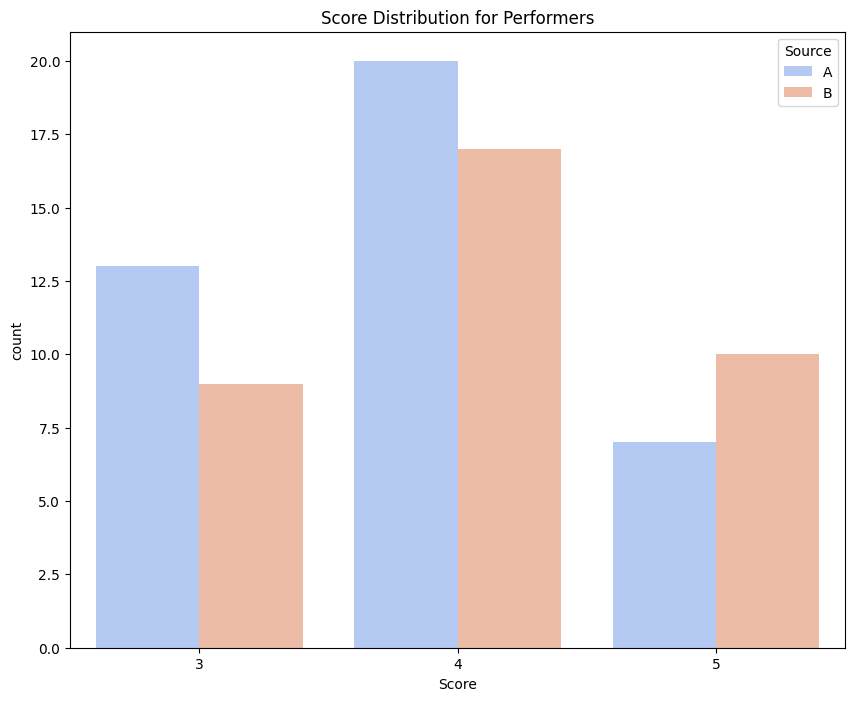

In [98]:
score_dist = df_sme.groupby(['Source', 'Score']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 8))
sns.countplot(data=df_sme, x="Score", hue="Source", palette='coolwarm')
plt.title("Score Distribution for Performers")
plt.show()

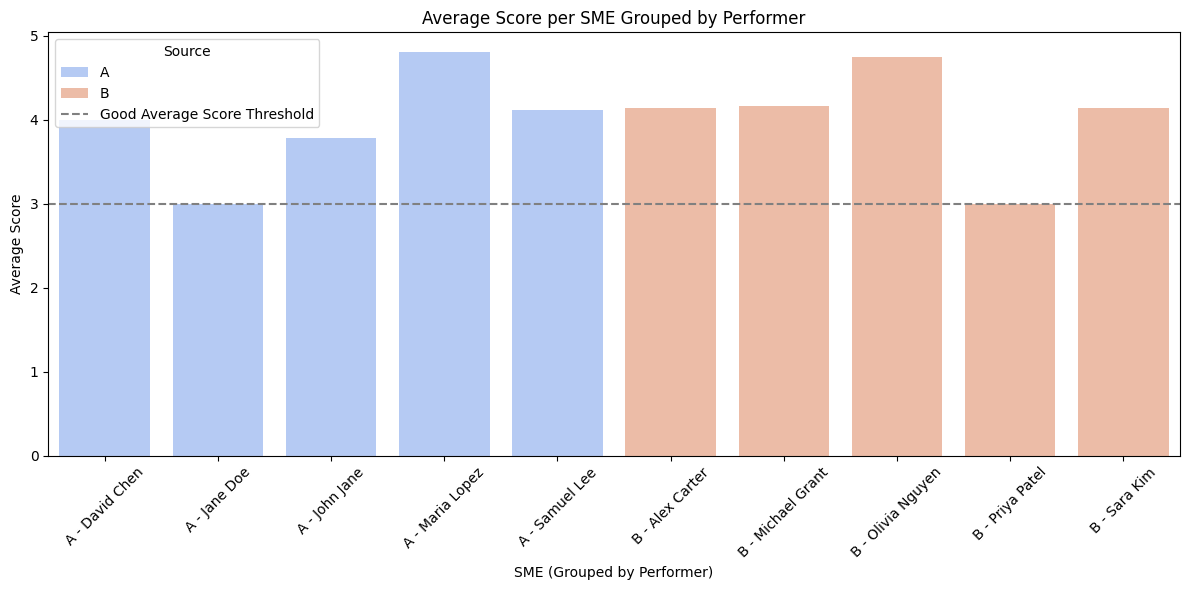

In [99]:
sme_stats['Group'] = sme_stats['Source'] + ' - ' + sme_stats['SME_ID']

plt.figure(figsize=(12, 6))
sns.barplot(data=sme_stats, x='Group', y='avg_score', hue='Source', palette='coolwarm')

plt.axhline(3, color='gray', linestyle='--', label='Good Average Score Threshold')

plt.title("Average Score per SME Grouped by Performer")
plt.ylabel("Average Score")
plt.xlabel("SME (Grouped by Performer)")
plt.xticks(rotation=45)
plt.legend(title='Source')
plt.tight_layout()
plt.show()

Boxplots and density plots to further support a recommendation on the most reliable SME scoring across the groups.

Low variance in scores across SMEs = reliable agreement.
High variance = disagreement among reviewers ~ inconsistency.

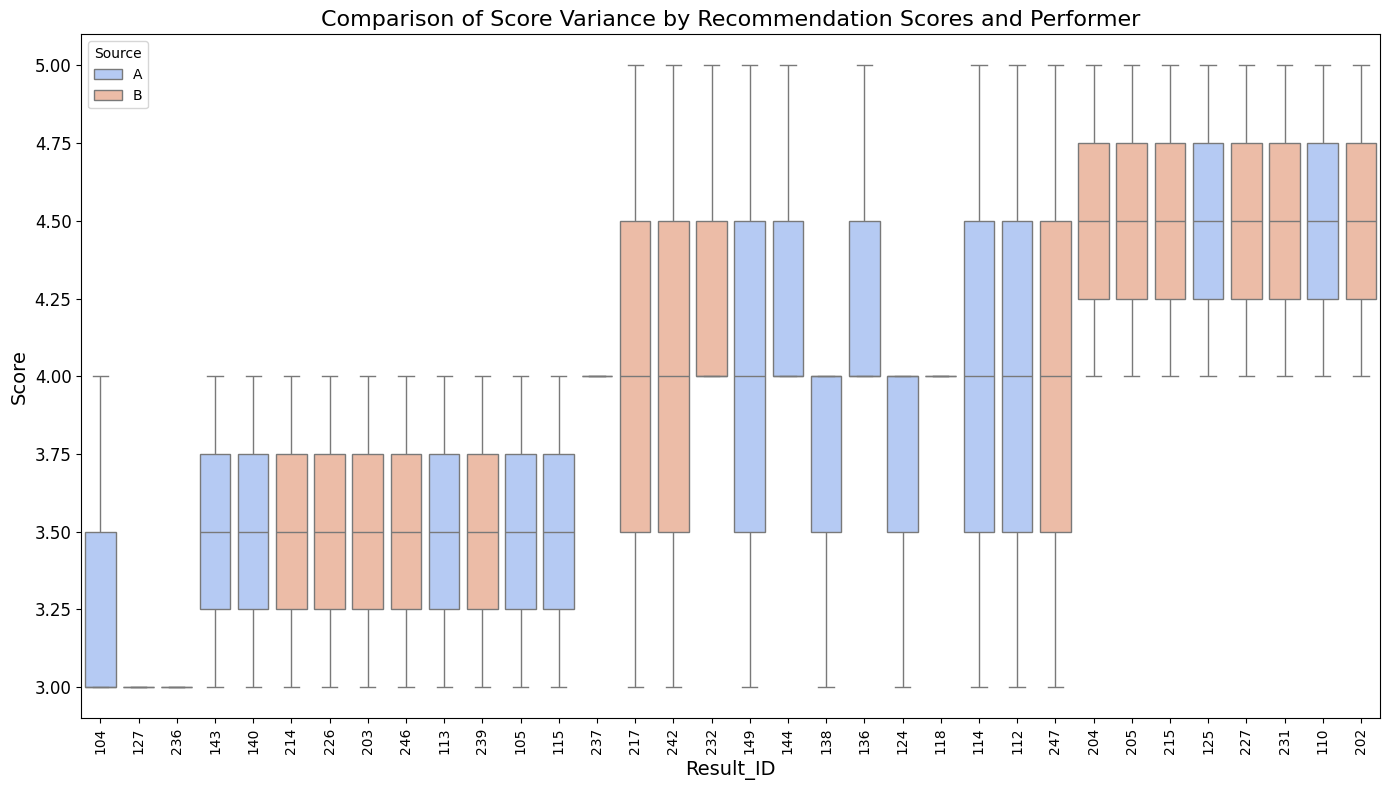

In [101]:
median_scores = df_sme.groupby('Result_ID')['Score'].median().sort_values()
sorted_result_ids = median_scores.index.tolist()

plt.figure(figsize=(14, 8))
sns.boxplot(x='Result_ID', y='Score', hue='Source', data=df_sme, palette='coolwarm', order=sorted_result_ids)
plt.title('Comparison of Score Variance by Recommendation Scores and Performer', fontsize=16)
plt.xlabel('Result_ID', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

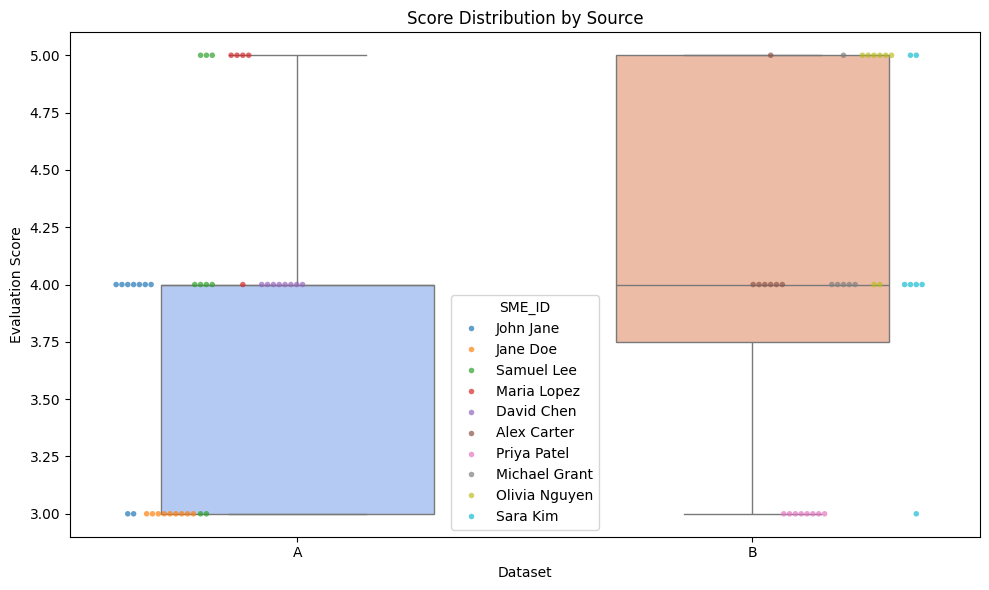

In [103]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_sme, x='Source', y='Score', width=0.6, palette='coolwarm', hue='Source', fliersize=0)
#sns.stripplot(data=df_sme, x='Source', y='Score', color='red', alpha=0.3, jitter=True, size=6)
sns.swarmplot(data=df_sme, x='Source', y='Score', hue='SME_ID', dodge=True, alpha=0.7, size=4)
plt.title('Score Distribution by Source')
plt.xlabel('Dataset')
plt.ylabel('Evaluation Score')
plt.tight_layout()
plt.show()

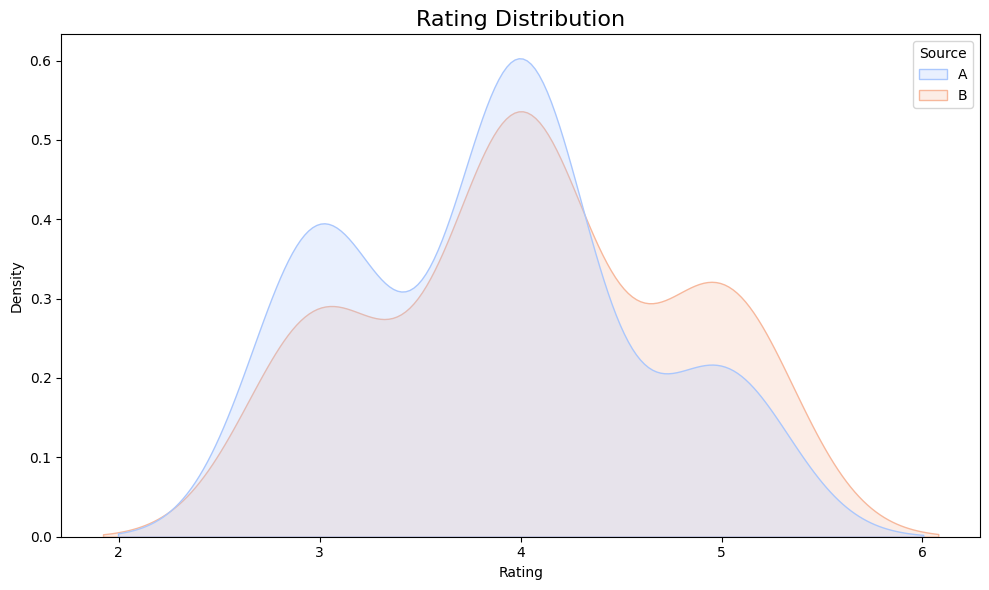

In [104]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_sme, x='Score', hue='Source', palette='coolwarm', fill=True, common_norm=False)
plt.title("Rating Distribution", fontsize=16)
plt.xlabel("Rating")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

Confirming the above look at variance between the groups via two hypothesis tests [8].

- Mann–Whitney U Test: If the p-value is much greater than the common significance level (e.g. 0.05), then we fail to reject the null hypothesis. This indicates that there is no significant difference between the distributions of the two groups being compared.
- Kolmogorov–Smirnov Test: If the p-value is significantly higher than the typical significance level (e.g. 0.05), then we fail to reject the null hypothesis. This suggests that there is no significant difference between the distributions of the two datasets being analyzed.

In addition to comparing average scores and variances, these non-parametric tests determine if the performance difference between Model A and B is statistically significant. This provides more information for defensible conclusions on which model is better.

In [105]:
u_stat, p_val_u = mannwhitneyu(df_sme[df_sme['Source'] == 'A']['Score'], 
                               df_sme[df_sme['Source'] == 'B']['Score'], 
                               alternative='two-sided')

ks_stat, p_val_ks = ks_2samp(df_sme[df_sme['Source'] == 'A']['Score'], 
                             df_sme[df_sme['Source'] == 'B']['Score'])


if p_val_u < 0.05:
    print(f"Mann–Whitney U Test: U={u_stat:.3f}, p={p_val_u:.3f} - Reject null hypothesis (significant difference)")
else:
    print(f"Mann–Whitney U Test: U={u_stat:.3f}, p={p_val_u:.3f} - Accept null hypothesis (no significant difference)")

if p_val_ks < 0.05:
    print(f"Kolmogorov–Smirnov Test: D={ks_stat:.3f}, p={p_val_ks:.3f} - Reject null hypothesis (significant difference)")
else:
    print(f"Kolmogorov–Smirnov Test: D={ks_stat:.3f}, p={p_val_ks:.3f} - Accept null hypothesis (no significant difference)")


Mann–Whitney U Test: U=625.500, p=0.289 - Accept null hypothesis (no significant difference)
Kolmogorov–Smirnov Test: D=0.103, p=0.970 - Accept null hypothesis (no significant difference)


### 16) SME Comment and Score Meta-Analysis

**LLM-based analysis** [9].

The use of one or more LLMs adds additional context with its analysis of the free-text comments from SMEs. This can help uncover the *reasons* behind the scores by identifying recurring themes, sentiment, and patterns (such as one model being consistently praised for "accuracy" while the other is noted for "clarity"). Some other features:

- Look for patterns in the feedback comments that indicate how close the recommendations are to the reviewers' expectations. For example, if one system is consistently praised for providing "accurate" or "reliable" recommendations, it may be seen as more accurate.
- Review the comments to see if reviewers are giving similar reasoning for their scores. For instance, if many reviers comment that the recomendation is "spot on," the recommendation is seen as reliable. On the other hand, if the comments are mixed or contradictory, it will likely mean lower reliability.
- Look at scores and comments, as uncertainty might also appear if the same recommendation is critiqued in multiple ways, like if one evaluator says it’s "too broad" while another says it’s "too narrow," pointing to inconsistency in the output. 

In [106]:
llm_prompt = dedent(f"""
Objective:

We aim to assess the quality and consistency of the Subject Matter Experts' (SMEs) feedback in relation to the scores provided for different recommendations. 
The data provided below (Results Table and Additional Information), in the Results Table, contains SME (SME_ID) evaluations for multiple recommendations (Result_ID), each assessed with a score (ranging from 1 to 5) and a comment offering further context. Make sure to take into account sample size, differences in number of results, and an Intraclass Correlation Coefficient (ICC) analysis results and other information in the Additional Information section. The focus will be on evaluating how well the comments align with the assigned scores (Score) and identifying which group (Source) of recommendations—**Group A or Group B**—provides more reliable and consistent feedback. Furthermore, if there are not enough samples or consistency in reviews, then say so with recommendations.

Evaluation Criteria:

- Score-Comment Alignment: Examine the relationship between the SME scores and the content of their comments. Identify whether higher scores align with positive comments and lower scores with negative feedback. Investigate any inconsistencies between scores and comments.
- Comment Quality: Assess the depth, clarity, and usefulness of the comments. Are the comments detailed, specific, and constructive? Do they provide actionable insights into the strengths or weaknesses of the recommendations?
- Consistency Across SMEs: Compare the feedback provided by different SMEs within each group (**A or B**). Identify any patterns in the feedback across SMEs—are the evaluations consistent, or do they vary widely?
- Recommendation Group Comparison: Based on the consistency and quality of the comments and scores, determine which group (**A or B**) offers more reliable and actionable feedback. Provide a clear rationale based on the patterns observed in the evaluation data.

Deliverables:

- Summary of Results: A brief description of each recommendation's performance based on the average score and the general sentiment of the comments. Emphasize how well the comments align with the scores.
- Score-Comment Analysis: A breakdown of the alignment between scores and comments for each recommendation. Identify any discrepancies between the feedback and the scores, and analyze the quality of the comments (e.g., are they constructive, specific, and insightful?).
- Group Comparison: Analyze the consistency and quality of the feedback within Group A versus Group B. Which group provides more reliable and consistent feedback based on the alignment between scores and comments? Justify your conclusion with specific examples from the data.
- Suggestions for Improvement: Based on the quality of the comments and the alignment with scores, provide suggestions for improving recommendations that received lower scores. Focus on areas where comments pointed to specific weaknesses that could be addressed to improve overall quality and clarity.

Results Table:

{df_sme}

Additional Information:

Grouped Descriptive Statistics:
{stats}

SME Descriptive Statistics:
{sme_stats}

ICC Summary Table:
{icc}

Hypothesis Test Results:
- Mann–Whitney U Test: U = {u_stat}, p = {p_val_u}
- Kolmogorov–Smirnov Test: KS = {ks_stat}, p = {p_val_ks}
""")

Cut-and-paste the below printout into your LLM of choice.

In [107]:
print(llm_prompt)


Objective:

We aim to assess the quality and consistency of the Subject Matter Experts' (SMEs) feedback in relation to the scores provided for different recommendations. 
The data provided below (Results Table and Additional Information), in the Results Table, contains SME (SME_ID) evaluations for multiple recommendations (Result_ID), each assessed with a score (ranging from 1 to 5) and a comment offering further context. Make sure to take into account sample size, differences in number of results, and an Intraclass Correlation Coefficient (ICC) analysis results and other information in the Additional Information section. The focus will be on evaluating how well the comments align with the assigned scores (Score) and identifying which group (Source) of recommendations—**Group A or Group B**—provides more reliable and consistent feedback. Furthermore, if there are not enough samples or consistency in reviews, then say so with recommendations.

Evaluation Criteria:

- Score-Comment Alig

Cut-and-paste the LLM report (response) below and edit as needed.


#### REPORT: LLM Meta-Analysis (ChatGPT 4o)

🔹 1. Summary of Results

| Group | Avg Score | Median | Std Dev | Count | General Sentiment                                                                          |
| :---- | :-------- | :----- | :------ | :---- | :----------------------------------------------------------------------------------------- |
| **A** | 3.85      | 4      | 0.70    | 40    | Moderately positive; frequent mentions of “good,” “solid,” or “reasonable” fit             |
| **B** | 4.03      | 4      | 0.74    | 36    | Slightly stronger positivity; more “excellent,” “perfect,” and “strong alignment” phrasing |

Observations:

* Both groups average close to **“Good” (≈4)**.
* **Group B’s slightly higher mean (4.03 vs 3.85)** and similar variability (0.74 vs 0.70) suggest comparable but slightly more optimistic evaluations.
* The **Mann–Whitney U test (p = 0.29)** and **KS test (p = 0.97)** indicate **no statistically significant difference** between Groups A and B’s scoring distributions.
* **ICC results show low to negligible inter-rater reliability (ICC < 0.1)** — meaning SME scores are largely inconsistent across raters.

---

🔹 2. Score–Comment Alignment Analysis

Method:

Each comment was reviewed qualitatively to assess alignment between sentiment and numerical score.

| Score Range           | Expected Tone                          | Observed Alignment (Group A)           | Observed Alignment (Group B)                         |
| --------------------- | -------------------------------------- | -------------------------------------- | ---------------------------------------------------- |
| **5 (Excellent)**     | “Perfect,” “Ideal,” “Strong alignment” | Comments match strongly                | Strongly consistent; often more enthusiastic         |
| **4 (Good)**          | “Solid,” “Reasonable,” “Good fit”      | Generally matches                      | Consistent and supportive; rarely contradicts        |
| **3 (Fair/Adequate)** | “Adequate,” “Reasonable but...”        | Comments match (notably from Jane Doe) | Consistent but sometimes overly positive for score 3 |

Alignment Observations:

* **High textual–numerical consistency overall**, especially for 4–5 ratings.
* **Group A**: SME *Jane Doe* consistently rated 3s with neutral-to-slightly negative phrasing (“Adequate,” “Reasonable match”)—strong internal consistency, though low variance.
* **Group B**: SME *Priya Patel* also assigned consistent 3s, though her comments were often generic (“Reasonable fit,” “Acceptable match”), indicating less depth.
* No clear mismatches (e.g., negative comments with high scores or vice versa).

✅ **Conclusion:** Both groups’ scores align well with comment sentiment. However, Group B’s comments occasionally exhibit *inflated positivity* (slightly too positive for midrange scores), suggesting **mild leniency bias**.

---

🔹 3. Comment Quality Evaluation

| Aspect               | Group A                                                                                               | Group B                                                                                   |
| -------------------- | ----------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------- |
| **Specificity**      | Moderately high; many mention “education alignment,” “experience weighting,” or “career progression.” | Similar; mentions of “technical depth,” “career trajectory,” and “domain relevance.”      |
| **Constructiveness** | Generally constructive; suggestions such as “weigh recency more heavily” or “tighten role fit.”       | Often descriptive rather than prescriptive (“solid fit,” “appropriate match”).            |
| **Clarity**          | Clear phrasing, minimal ambiguity.                                                                    | Clear but slightly repetitive; uses standard evaluative language.                         |
| **Depth/Insight**    | Some SMEs (e.g., Maria Lopez, Samuel Lee) provide thoughtful context.                                 | Most SMEs provide short, formulaic praise; Olivia Nguyen stands out for detailed remarks. |

✅ **Conclusion:**

* **Group A comments** show *slightly higher diagnostic value* (pointing to concrete improvement areas).
* **Group B comments** are polished but less actionable — more evaluative than instructive.

---

🔹 4. Consistency Across SMEs

| Group | ICC3 (fixed raters)      | Within-group SME variance                                    | Notable Outliers                                                            | Interpretation                                          |
| ----- | ------------------------ | ------------------------------------------------------------ | --------------------------------------------------------------------------- | ------------------------------------------------------- |
| **A** | ~0.03                    | Jane Doe (3.0) and Maria Lopez (4.8) show high divergence    | Jane Doe’s consistently low scores and Lopez’s high ones reduce reliability | Weak consistency — opinions differ strongly across SMEs |
| **B** | ~0.03 (same overall ICC) | Priya Patel (3.0) vs. Olivia Nguyen (4.75) diverge similarly | Bimodal tendencies (lenient vs strict raters)                               | Similar inconsistency level; slightly tighter midrange  |

Even though both groups show **low inter-rater reliability**, **Group B’s smaller score variance per SME** (e.g., Alex Carter 0.14 vs Samuel Lee 0.61 in A) suggests *slightly higher internal consistency*.

✅ **Conclusion:**
Neither group shows strong inter-rater consistency, but **Group B** demonstrates *slightly more cohesive scoring behavior* (less spread, lower within-rater variance).

---

🔹 5. Group Comparison Summary

| Criterion                   | Group A                                        | Group B                                   | Better Group                                                 |
| --------------------------- | ---------------------------------------------- | ----------------------------------------- | ------------------------------------------------------------ |
| **Average Score**           | 3.85                                           | 4.03                                      | B (marginally higher)                                        |
| **Score–Comment Alignment** | Strong                                         | Slightly inflated positivity              | A (tighter semantic match)                                   |
| **Comment Quality**         | More actionable, improvement-oriented          | Clearer but less specific                 | A                                                            |
| **Consistency Across SMEs** | Higher variance among raters                   | Slightly lower variance                   | B                                                            |
| **Overall Reliability**     | Mixed consistency, better qualitative feedback | Slightly steadier scores, less diagnostic | **≈ Draw — B edges slightly on reliability, A on substance** |

**Final Judgment:**

> **Group B** shows marginally *higher reliability and consistency*, while **Group A** offers *richer and more actionable comments*.
> If the goal is **reliable scoring**, choose **Group B**.
> If the goal is **insightful feedback for improvement**, choose **Group A**.

---

🔹 6. Suggestions for Improvement

For Low-Scoring Recommendations (Scores = 3)

* **Address identified gaps:** Comments consistently cite “role fit,” “recency weighting,” and “education match.” Prioritize adjusting matching algorithms to weigh:

  * Most recent job experience more heavily.
  * Specific domain alignment over general experience.
* **Encourage SMEs** to expand “adequate” or “reasonable” comments with at least one improvement point (e.g., “Adjust weight on X to improve fit.”).
* **Calibration training:** Given low ICC, organize calibration sessions so SMEs align on what constitutes a 3 vs. 4 score.

For SMEs

* **Jane Doe and Priya Patel** (consistently low and generic): Encourage deeper rationales behind low scores.
* **Maria Lopez and Olivia Nguyen** (consistently high): Add justification for high scores to avoid inflation perception.

---

🔹 7. Executive Summary

* **Scores between Groups A and B do not significantly differ** (p > 0.28), but both show **low inter-rater reliability** (ICC ≈ 0.03).
* **Group A’s feedback**: More detailed and improvement-oriented but more variable between raters.
* **Group B’s feedback**: Slightly more consistent and cohesive, but comments tend to be more general and less actionable.
* **Next Steps:** Standardize rating guidelines, run calibration sessions, and require SMEs to justify outlier ratings.


## Notes


## Appendix A


## Appendix B

ICC summary table description


| **Column**    | **Description**                                                                                                                                                 |
|---------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Type**      | Describes the type of ICC calculation.                                                                                                                           |
|               | - **ICC1**: Single raters, absolute agreement (measures single rater's reliability with respect to absolute agreement).                                         |
|               | - **ICC2**: Single raters, random raters (measures single rater's reliability with respect to random raters).                                                   |
|               | - **ICC3**: Single raters, fixed raters (measures single rater's reliability with respect to fixed raters).                                                     |
|               | - **ICC1k**: Average raters, absolute agreement (measures average rater's reliability with respect to absolute agreement).                                       |
|               | - **ICC2k**: Average raters, random raters (measures average rater's reliability with respect to random raters).                                                 |
|               | - **ICC3k**: Average raters, fixed raters (measures average rater's reliability with respect to fixed raters).                                                   |
| **Description**| Describes each type of ICC in more detail, e.g., whether it refers to single raters or average raters, and whether the raters are fixed or random.           |
| **ICC**       | Intraclass Correlation Coefficient (ICC) value.                                                                                                                  |
|               | - **ICC close to 1**: High reliability, consistent ratings across raters. [Excellent agreement]                                                                                      |
|               | - **ICC close to 0**: Low reliability, inconsistent ratings across raters.                                                                                     |
|               | - **Negative ICC**: Poor reliability, even worse than random disagreement.                                                                                      |
| **F**         | F-statistic, used to assess whether the variability between ratings is significantly greater than within-ratings variability.                                     |
|               | - A higher **F** indicates a larger difference between raters and the ratings themselves.                                                                        |
| **df1**       | Degrees of freedom for the numerator in the F-statistic (number of groups/targets).                                                                            |
| **df2**       | Degrees of freedom for the denominator in the F-statistic (number of raters).                                                                                  |
| **pval**      | p-value indicating statistical significance.                                                                                                                   |
|               | - **p-value < 0.05**: The ICC is statistically significant, meaning there is good consistency among raters.                                                      |
|               | - **p-value ≥ 0.05**: The ICC is not statistically significant, suggesting poor consistency among raters.                                                        |
| **CI95%**     | 95% Confidence Interval for the ICC.                                                                                                                             |
|               | - If the CI includes zero or negative values, the ICC is not statistically significant.                                                                        |
|               | - If the CI does not include zero, the ICC is more likely to be statistically significant.                                                                      |

## Appendix C

Windows PowerShell script to duplicate and rename files (I used this to organize and assign separate AI outputs to each individual SME).

Note that I am not a Windows person so leveraged an LLM to assist!!


In [0]:
# 1) copy this script and save as a .ps1 file
# 2) make sure template and other input files paths are correct
# 3) run script in some current folder (I used Downloads) as follows:
# PS> .\copy_files.ps1
 
$templatePath = "template.docx"
 
# $idListPath = "ids_ibr.txt"
# $idListPath = "ids_deloitte.txt"
 
# $outputFolder = "C:\Users\1066409577.CIV\OneDrive - US Navy-flankspeed\Documents\Talent Management\1814 OTAs\IBR\AI_TE\ai_outputs"
# $outputFolder = "C:\Users\1066409577.CIV\OneDrive - US Navy-flankspeed\Documents\Talent Management\1814 OTAs\Deloitte\AI_TE\ai_outputs"
 
# Create the output folder if it doesn't exist
if (!(Test-Path -Path $outputFolder)) {
    New-Item -ItemType Directory -Path $outputFolder
}
 
# Read IDs from the text file
$ids = Get-Content -Path $idListPath
 
# Loop through each ID and copy/rename the template
foreach ($id in $ids) {
    # Trim any whitespace
    $id = $id.Trim()
    # Define destination file name with id_ prefix
    $fileName = "XYZ_id_$id.docx"
    $destinationPath = Join-Path -Path $outputFolder -ChildPath $fileName
    # Copy the template file to the new destination
    Copy-Item -Path $templatePath -Destination $destinationPath
    Write-Host "Created file: $destinationPath"
}
 
Write-Host "Done creating files."

## References

1. Mbounthavong, Malithone. *Propensity Score in R*. RPubs. https://rpubs.com/mbounthavong/propensity_score_r.
2. Christoph Heindl. *RapidFuzz: Fuzzy String Matching in Python*. GitHub. https://github.com/maxbachmann/RapidFuzz.
3. Steven Loria. *TextBlob: Simplified Text Processing*. GitHub. https://github.com/sloria/TextBlob.
4. Wikipedia contributors. "Block Design." *Wikipedia, The Free Encyclopedia*. Last modified April 19, 2024. https://en.wikipedia.org/wiki/Block_design.
5. Montgomery, D. C. (2017). Design and analysis of experiments (9th ed.). Wiley. https://www.researchgate.net/publication/362079778_Design_and_Analysis_of_Experiments_9th_Edition
6. Koo, Terry K., and Mae Y. Li. "A Guideline of Selecting and Reporting Intraclass Correlation Coefficients for Reliability Research." *Journal of Chiropractic Medicine* 15, no. 2 (2016): 155–163. https://doi.org/10.1016/j.jcm.2016.02.012.
7. Shrout, P. E., & Fleiss, J. L. (1979). Intraclass correlations: Uses in assessing rater reliability. Psychological Bulletin, 86(2), 420–428. https://doi.org/10.1037/0033-2909.86.2.420
8. Gibbons, J.D., Chakraborti, S. (2011). Nonparametric Statistical Inference. In: Lovric, M. (eds) International Encyclopedia of Statistical Science. Springer, Berlin, Heidelberg. https://doi.org/10.1007/978-3-642-04898-2_420 
9. OpenAI. *ChatGPT*. https://chat.openai.com.